<a href="https://colab.research.google.com/github/sombr3ro/Machine-Learning-Repo/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
train_data = FashionMNIST(root = "data", train = True, transform = transforms.ToTensor(), download=True)
test_data = FashionMNIST(root = 'data', train=False, transform = transforms.ToTensor(), download=True )


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
tr

In [ ]:
labels = train_data.classes

In [ ]:
print(train_data.data.shape)

torch.Size([60000, 28, 28])


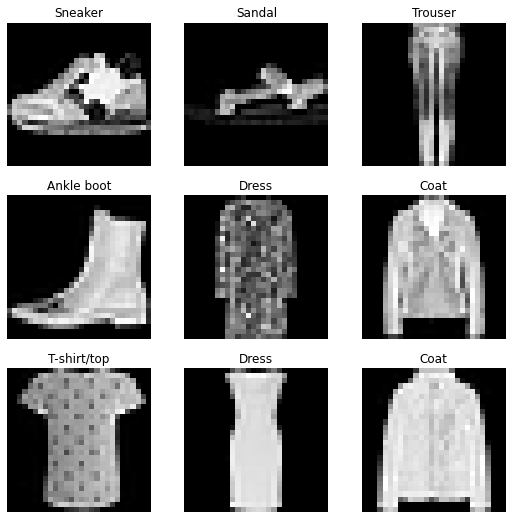

In [ ]:
rows = 3
cols = 3
fig,axs = plt.subplots(rows,cols, figsize = (9,9))

for i in range(rows):
  for j in range(cols):
    ax = axs[i,j]
    ax.axis('off')
    num = np.random.randint(len(train_data))
    img = train_data.data[num]
    label = labels[train_data.targets[num].item()]
    ax.imshow(img, cmap = 'gray')
    ax.set_title(label)

In [ ]:
batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class FashionExpert(nn.Module):
  def __init__(self):
    super(FashionExpert,self).__init__()
    self.convStack = nn.Sequential(
      nn.Conv2d(1,32,(3,3),2),
      nn.ReLU(),
      nn.Conv2d(32,64,(3,3),2),
      nn.ReLU(),
      nn.Conv2d(64,128,(3,3),2),
      nn.ReLU()
      #nn.AdaptiveMaxPool2d(1)
    )
    self.flatten = nn.Flatten(start_dim=1)
    self.linearStack = nn.Sequential(
      nn.Dropout(0.2),
      nn.Linear(512,512),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(512,10),
    )
  
  def forward(self,x):
    #x = torch.unsqueeze(x,dim=1)
    x = x/255.0
    x = self.convStack(x)
    x = self.flatten(x).squeeze()
    logits = self.linearStack(x)
    return logits

In [ ]:
model = FashionExpert().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

FashionExpert(
  (convStack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linearStack): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
def train(data_loader, model, loss_fn, optim, size):
  loss_val =0.0
  accuracy = 0.0
  for batch,(x,y) in enumerate(data_loader):
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    loss = loss_fn(pred,y)
    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_val +=loss.item()
    accuracy += (pred.argmax(1)==y).type(torch.float).sum().item()

    #if ((batch+1)%10==0):
    #  print(f"{batch+1}th batch training loss: {loss.item()}")

  loss_val = loss_val/size
  accuracy = accuracy/size*100
    
  return loss_val,accuracy

In [ ]:
def test(data_loader, model, loss_fn, size):
  loss_val = 0.0
  accuracy = 0.0
  for (x,y) in data_loader:
    x = x.to(device)
    y = y.to(device)

    model.eval()
    with torch.no_grad():
      pred = model(x)
      loss = loss_fn(pred,y)
      loss_val+= loss.item()
      accuracy += (pred.argmax(1)==y).type(torch.float).sum().item()
  
  loss_val = loss_val/size
  accuracy = accuracy/size*100.0

  return loss_val,accuracy

In [ ]:
train_loss = []
train_acc =[]
test_loss = []
test_acc = []

epoch = 100
train_size = float(len(train_data))
test_size = float(len(test_data))

for i in range(epoch):
  
  print(f"epoch {i} -------------------------------")
  
  loss,acc = train(train_loader,model,loss_fn,optim, train_size)
  train_loss.append(loss)
  train_acc.append(acc)

  print(f"Training Data: loss: {loss} \t accuracy: {acc}")

  loss,acc = test(test_loader,model,loss_fn,test_size)
  test_loss.append(loss)
  test_acc.append(acc)

  print(f"Test Data: loss: {loss} \t accuracy: {acc}")


print("Done")

epoch 0 -------------------------------
Training Data: loss: 0.004529194227854411 	 accuracy: 9.959999999999999
Test Data: loss: 0.004605228924751282 	 accuracy: 10.0
epoch 1 -------------------------------
Training Data: loss: 0.004528868770599365 	 accuracy: 10.031666666666666
Test Data: loss: 0.004605294156074524 	 accuracy: 10.0
epoch 2 -------------------------------
Training Data: loss: 0.004527170538902283 	 accuracy: 10.943333333333333
Test Data: loss: 0.004582627725601196 	 accuracy: 17.46
epoch 3 -------------------------------
Training Data: loss: 0.00293936259051164 	 accuracy: 47.00166666666667
Test Data: loss: 0.0020195623636245726 	 accuracy: 63.65
epoch 4 -------------------------------
Training Data: loss: 0.0018382016907135645 	 accuracy: 65.94833333333334
Test Data: loss: 0.0017737492740154267 	 accuracy: 67.24
epoch 5 -------------------------------
Training Data: loss: 0.0015965929090976715 	 accuracy: 70.01333333333334
Test Data: loss: 0.0015813334584236145 	 accu

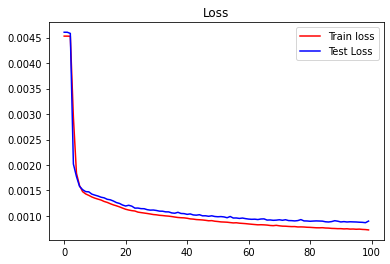

In [ ]:
fig = plt.figure()
plt.title("Loss")
plt.plot(train_loss, 'r', label = 'Train loss')
plt.plot(test_loss, 'b', label = "Test Loss")
plt.legend()

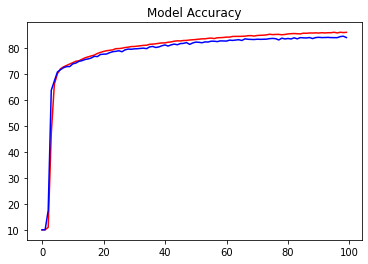

In [ ]:
fig = plt.figure()
plt.title("Model Accuracy")
plt.plot(train_acc, 'r', label='train accuracy')
plt.plot(test_acc,'b', label= 'test accuracy')

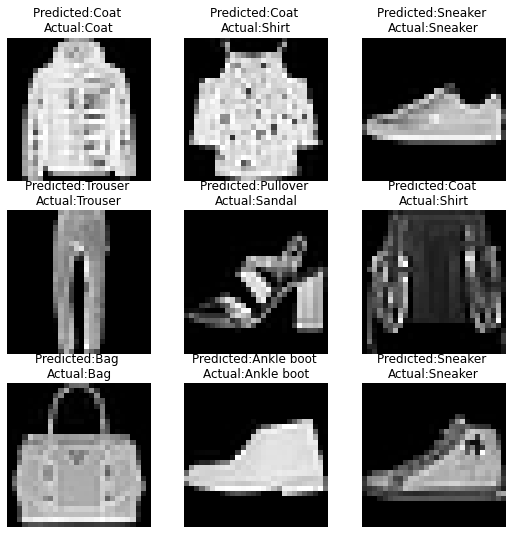

In [ ]:
row = 3
col = 3
fig,axs = plt.subplots(3,3, figsize = (9,9))

model.eval()
for i in range(row):
  for j in range(col):
    ax = axs[i,j]
    idx = np.random.randint(len(test_data))
    img = np.array(test_data.data[idx])
    label = labels[test_data.targets[idx]]
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')

    with torch.no_grad():
      x = torch.from_numpy(img)
      x = x.to(device)
      x= torch.unsqueeze(x, 0)
      x= torch.unsqueeze(x, 0)
      pred = model(x)
      pred_val = pred.argmax().item()
    
    pred_label = labels[pred_val]
    ax.set_title(f"Predicted:{pred_label} \nActual:{label}")
    